# Kernel-based Time-varying Regression - Part IV

This is final tutorial on **KTR**. It continues from **Part III** with additional details on some of the advanced arguments.  For other details on **KTR** see either the previous three tutorials or the original paper Ng, Wang and Dai (2021).

In **Part IV** covers advance inputs for regression including

- regressors signs
- time-point coefficients priors


In [1]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTR
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.plot import get_orbit_style
from orbit.utils.kernels import gauss_kernel
from orbit.constants.palette import OrbitPalette

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)
orbit_style = get_orbit_style()
plt.style.use(orbit_style);

In [2]:
print(orbit.__version__)

1.1.4.3


## Data

To demonstrate the effect of specifying regressors coefficients sign, it is helpful to modify the data simulation code from **part II**. The simulation is altered to impose strictly positive regression coefficients. 

In the **KTR** model below, the coefficient curves are approximated with **Gaussian kernels** having positive values of knots. The levels are also included in the process with vector of ones as the covariates. 

The parameters used to setup the data simulation are:

- `n` : number of time steps
- `p` : number of predictors

In [3]:
np.random.seed(2021)

n = 300
p = 2
tp = np.arange(1, 301) / 300
knot_tp = np.array([1, 100, 200, 300]) / 300
beta_knot = np.array(
    [[1.0, 0.1, 0.15],
     [3.0, 0.01, 0.05],
     [3.0, 0.01, 0.05],
     [2.0, 0.05, 0.02]]
)

gk = gauss_kernel(tp, knot_tp, rho=0.2)
beta = np.matmul(gk, beta_knot)
covar_lev = np.ones((n, 1))
covar = np.concatenate((covar_lev, np.random.normal(0, 1.0, (n, p))), axis=1)\

# observation with noise
y = (covar * beta).sum(-1) + np.random.normal(0, 0.1, n)


regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
data = pd.DataFrame(covar[:,1:], columns=regressor_col)
data['y'] = y
data['date'] = pd.date_range(start='1/1/2018', periods=len(y))
data = data[['date', 'y'] + regressor_col]
beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
beta_data = pd.DataFrame(beta[:,1:], columns=beta_col)

data = pd.concat([data, beta_data], axis=1)

In [4]:
data.tail(10)

,date,y,x1,x2,beta1,beta2
290,2018-10-18,2.15947,-0.62762,0.17840,0.04015,0.02739
291,2018-10-19,2.25871,-0.92975,0.81415,0.04036,0.02723
292,2018-10-20,2.18356,0.82438,-0.92705,0.04057,0.02707
293,2018-10-21,2.26948,1.57181,-0.78098,0.04077,0.02692
294,2018-10-22,2.26375,-1.07504,-0.86523,0.04097,0.02677
295,2018-10-23,2.21349,0.24637,-0.98398,0.04117,0.02663
296,2018-10-24,2.13297,-0.58716,0.59911,0.04136,0.02648
297,2018-10-25,2.00949,-2.01610,0.08618,0.04155,0.02634
298,2018-10-26,2.14302,0.33863,-0.37912,0.04173,0.02620
299,2018-10-27,2.10795,-0.96160,-0.42383,0.04192,0.02606


Just like previous tutorials in regression, some additional args are used to describe the regressors and the scale parameters for the knots.

In [5]:
ktr = KTR(
    response_col='y',
    date_col='date',
    regressor_col=regressor_col,
    regressor_init_knot_scale=[0.1] * p,
    regressor_knot_scale=[0.1] * p,
    prediction_percentiles=[2.5, 97.5],
    seed=2021,
    estimator='pyro-svi',
)
ktr.fit(df=data)

2024-01-21 14:25:31 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-01-21 14:25:31 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
/Users/towinazure/opt/miniconda3/envs/orbit39/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
2024-01-21 14:25:32 - orbit - INFO - step    0 loss = -3.5592, scale = 0.085307
INFO:orbit:step    0 loss = -3.5592, scale = 0.085307
2024-01-21 14:25:32 - orbit - INFO - step  100 loss = -228.72, scale = 0.036569
INFO:orbit:step  100 loss = -228.72, scale = 0.036569
2024-01-21 14:25:33 - orbit - INFO - step  200 loss = -228.83, scale = 0.037738
INFO:orbit

## Visualization of Regression Coefficient Curves

The `get_regression_coefs` argument is used to extract coefficients with intervals by supplying the argument `include_ci=True`.

In [6]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

The next figure shows the overlay of the estimate on the true coefficients. Since the lower bound is below zero some of the coefficient posterior samples are negative.

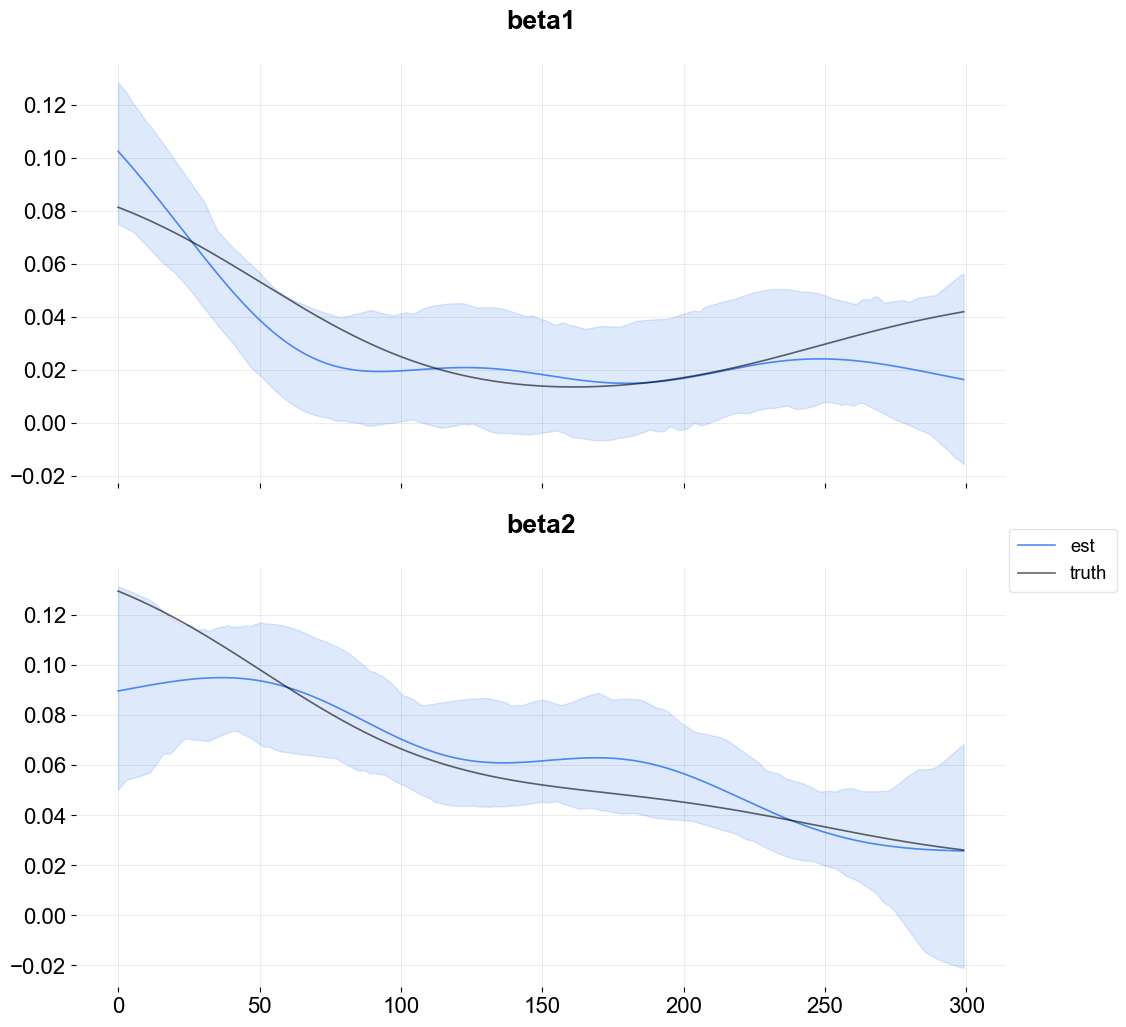

In [7]:
fig, axes = plt.subplots(p, 1, figsize=(12, 12), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est' if idx == 0 else "", alpha=0.8, color=OrbitPalette.BLUE.value)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.15, color=OrbitPalette.BLUE.value)
    axes[idx].plot(x, data['beta{}'.format(idx + 1)], label='truth' if idx == 0 else "", alpha=0.6, color = OrbitPalette.BLACK.value)
    axes[idx].set_title('beta{}'.format(idx + 1))

fig.legend(bbox_to_anchor = (1,0.5));

## Regressor Sign

Strictly positive coefficients can be imposed by using the `regressor_sign` arg. It can have values "=", "-",  or "+" which denote no restriction, strictly negative, strictly positive.  Note that it is possible to have a mixture by providing a list of strings one for each regressor. 

In [8]:
ktr = KTR(
    response_col='y',
    date_col='date',
    regressor_col=regressor_col,
    regressor_init_knot_scale=[0.1] * p,
    regressor_knot_scale=[0.1] * p,
    regressor_sign=['+'] * p,
    prediction_percentiles=[2.5, 97.5],
    seed=2021,
    estimator='pyro-svi',
)
ktr.fit(df=data)

2024-01-21 14:25:35 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-01-21 14:25:35 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2024-01-21 14:25:35 - orbit - INFO - step    0 loss = 9.7371, scale = 0.10482
INFO:orbit:step    0 loss = 9.7371, scale = 0.10482
2024-01-21 14:25:36 - orbit - INFO - step  100 loss = -231.22, scale = 0.41649
INFO:orbit:step  100 loss = -231.22, scale = 0.41649
2024-01-21 14:25:36 - orbit - INFO - step  200 loss = -230.89, scale = 0.426
INFO:orbit:step  200 loss = -230.89, scale = 0.426
2024-01-21 14:25:37 - orbit - INFO - step  300 loss = -229.25, scale = 0.4185
INFO:orbit:step  300 loss = -229.25, scale = 0.4185


In [9]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

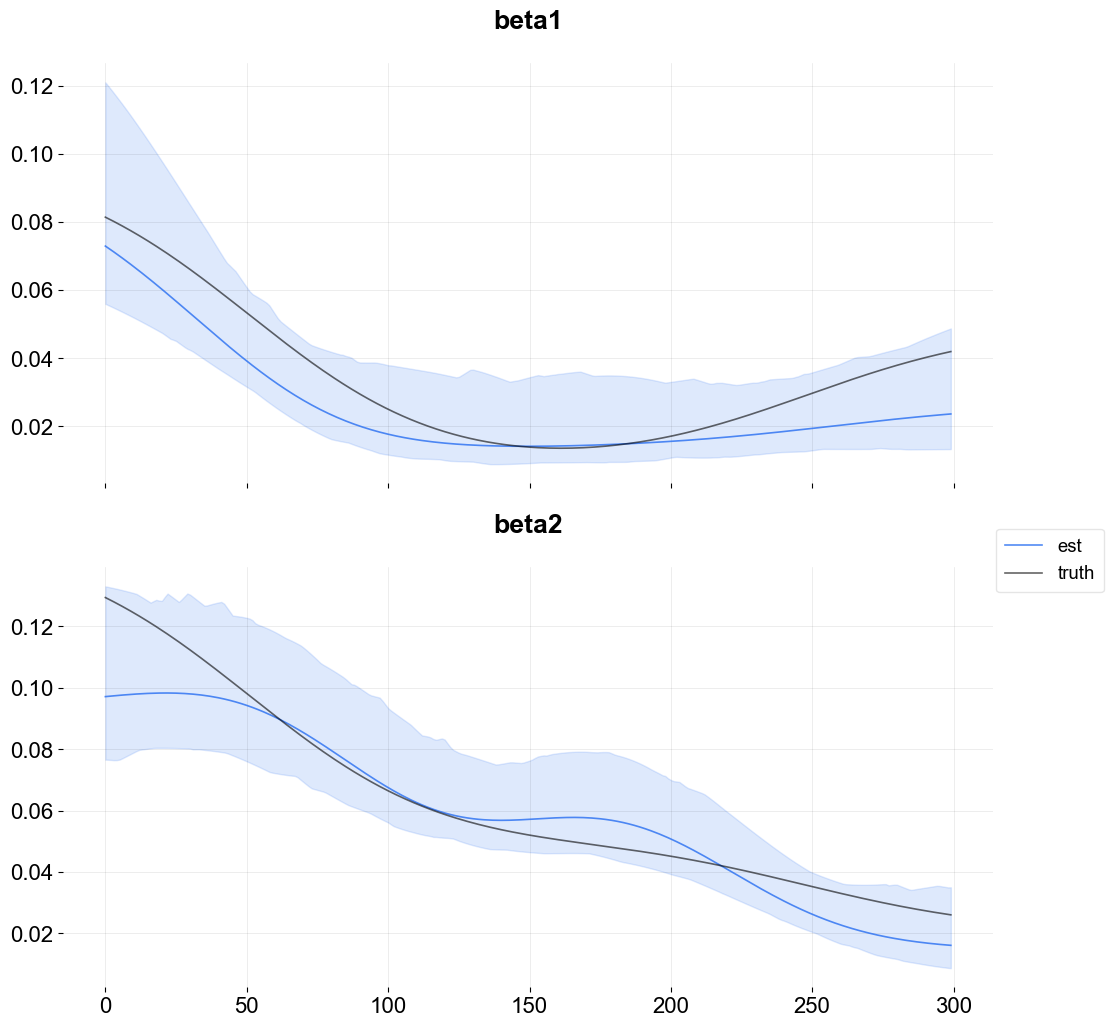

In [10]:
fig, axes = plt.subplots(p, 1, figsize=(12, 12), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est' if idx == 0 else "", alpha=0.8, color=OrbitPalette.BLUE.value)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.15, color=OrbitPalette.BLUE.value)
    axes[idx].plot(x, data['beta{}'.format(idx + 1)], label='truth' if idx == 0 else "",  alpha=0.6, color = OrbitPalette.BLACK.value)
    axes[idx].set_title('beta{}'.format(idx + 1))

fig.legend(bbox_to_anchor = (1,0.5));

Observe the curves lie in the positive range with a slightly improved fit relative to the last model.

To conclude, it is useful to have a strictly positive range of regression coefficients if that range is known a priori. **KTR** allows these priors to be specified.  For regression scenarios where there is no a priori knowledge  of the coefficient sign it is recommended to use the default which contains both sides of the range.  


## Time-point coefficient priors

Users can incorporate coefficient priors for any regressor and any time period. This feature is quite useful when users have some prior knowledge or beliefs on regressor coefficients. For example, if an A/B test is conducted for a certain regressor over a specific time range, then users can ingest the priors derived from such A/B test.

This can be done by supplying a list of dictionaries via `coef_prior_list`. Each dict in the list should have keys as `name`, `prior_start_tp_idx` (inclusive), `prior_end_tp_idx` (not inclusive), `prior_mean`, `prior_sd`, and `prior_regressor_col`.

Below is an illustrative example by using the simulated data above.

In [11]:
from copy import deepcopy

In [12]:
prior_duration = 50
coef_list_dict = []
prior_idx=[
    np.arange(150, 150 + prior_duration), 
    np.arange(200, 200 + prior_duration), 
]
regressor_idx = range(1, p + 1)
plot_dict = {}
for i in regressor_idx:
    plot_dict[i] = {'idx': [], 'val': []}

In [13]:
for idx, idx2, regressor in zip(prior_idx, regressor_idx, regressor_col):
    prior_dict = {}
    prior_dict['name'] = f'prior_{regressor}'
    prior_dict['prior_start_tp_idx'] = idx[0]
    prior_dict['prior_end_tp_idx'] = idx[-1] + 1
    prior_dict['prior_mean'] = beta[idx, idx2]
    prior_dict['prior_sd'] = [0.1] * len(idx)
    prior_dict['prior_regressor_col'] = [regressor] * len(idx)
    
    plot_dict[idx2]['idx'].extend(idx)
    plot_dict[idx2]['val'].extend(beta[idx, idx2])
     
    coef_list_dict.append(deepcopy(prior_dict)) 

In [14]:
ktr = KTR(
    response_col='y',
    date_col='date',
    regressor_col=regressor_col,
    regressor_init_knot_scale=[0.1] * p,
    regressor_knot_scale=[0.1] * p,
    regressor_sign=['+'] * p,
    coef_prior_list = coef_list_dict,
    prediction_percentiles=[2.5, 97.5],
    seed=2021,
    estimator='pyro-svi',
)
ktr.fit(df=data)

2024-01-21 14:25:38 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-01-21 14:25:38 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2024-01-21 14:25:38 - orbit - INFO - step    0 loss = -5741.9, scale = 0.094521
INFO:orbit:step    0 loss = -5741.9, scale = 0.094521
2024-01-21 14:25:39 - orbit - INFO - step  100 loss = -7140.3, scale = 0.31416
INFO:orbit:step  100 loss = -7140.3, scale = 0.31416
2024-01-21 14:25:41 - orbit - INFO - step  200 loss = -7140, scale = 0.31681
INFO:orbit:step  200 loss = -7140, scale = 0.31681
2024-01-21 14:25:43 - orbit - INFO - step  300 loss = -7140.6, scale = 0.3307
INFO:orbit:step  300 loss = -7140.6, scale = 0.3307


In [15]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

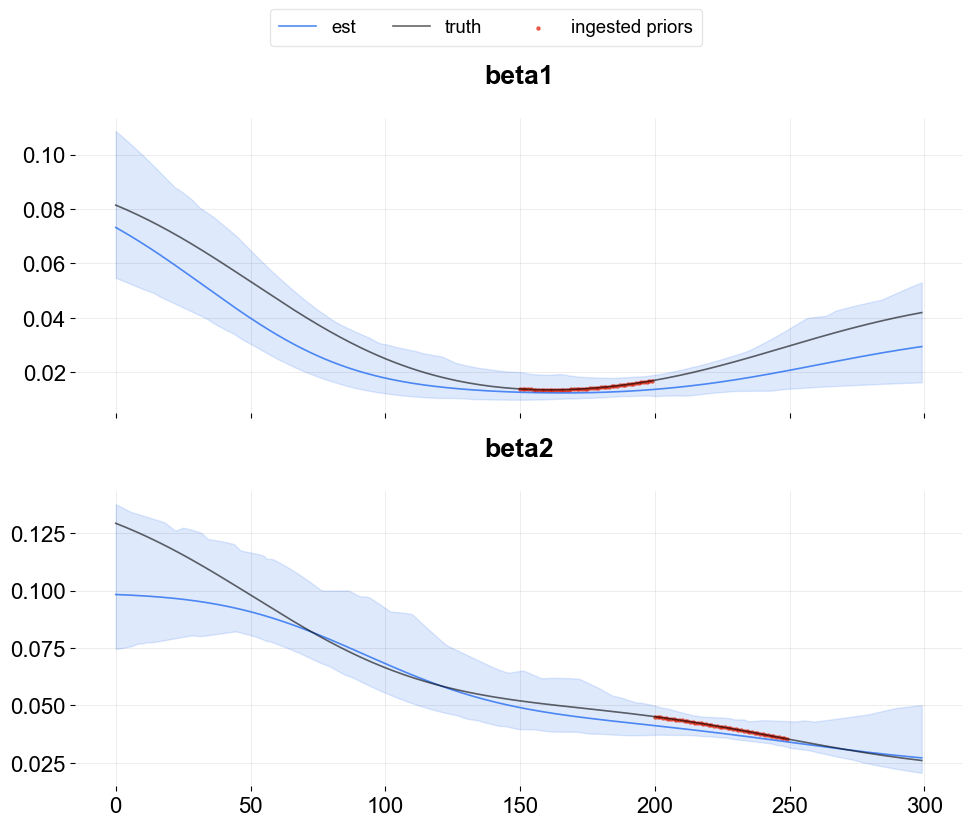

In [16]:
fig, axes = plt.subplots(p, 1, figsize=(10, 8), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est', alpha=0.8, color=OrbitPalette.BLUE.value)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.15, color=OrbitPalette.BLUE.value)
    axes[idx].plot(x, data['beta{}'.format(idx + 1)], label='truth', alpha=0.6, color = OrbitPalette.BLACK.value)
    axes[idx].set_title('beta{}'.format(idx + 1))
    axes[idx].scatter(plot_dict[idx + 1]['idx'], plot_dict[idx + 1]['val'],
                      s=5, color=OrbitPalette.RED.value, alpha=.6, label='ingested priors')
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(.5, 1.05))

plt.tight_layout()

As seen above, for the ingested prior time window, the estimation is aligned better with the truth and the resulting confidence interval also becomes narrower compared to other periods.

## References

1. Ng, Wang and Dai (2021). Bayesian Time Varying Coefficient Model with Applications to Marketing Mix Modeling, arXiv preprint arXiv:2106.03322 